In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import warnings

warnings.filterwarnings(action='ignore') 


mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

# 데이터 불러오기 및 기본적인 전처리

In [3]:
df=pd.read_csv('total_dataset.csv')
test=df[:10000]
test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace(',',''))
test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace('nan','0'))
test['PD_BUY_AM']=test['PD_BUY_AM'].astype('int')
test['Sales']=test['PD_BUY_AM']*test['PD_BUY_CT']
test['SESS_DT']=test['SESS_DT'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))


# 코호트 분석
1. 월별로 고객을 나눠서 집단을 구성한다.
2. 집단들 각각의 이탈율을 파악한다.

In [4]:
# 월별로 집단을 만들기 위해 month 컬럼을 만들었습니다.
test['SESS_DT_period'] = test.SESS_DT.apply(lambda x: x[:7])
test.set_index('CLNT_ID_y', inplace=True)
# 고객이 처음 들어온 월을 기준으로  코호트 그룹을 만들었습니다. 예를들어, 4월에 들어온 고객은 1그룹, 5월에 들어온 고객은 2그룹.
test['CohortGroup'] = test.groupby(level=0)['SESS_DT'].min().apply(lambda x: x[:7])
test.reset_index(inplace=True)
test.head()

,CLNT_ID_y,Unnamed: 0,CLNT_ID_x,SESS_ID,KWD_NM,SEARCH_CNT,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,CLNT_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM,CLNT_GENDER,CLNT_AGE,Sales,SESS_DT_period,CohortGroup
0,5607714,0,5607714.0,7112876,빌리프 아이크림,6.0,505,2018-06-03,113.0,897,mobile,Gyeonggi-do,Gwacheon-si,5607714,109,656297,기본:기본 / 1개,빌리프,48000,1,모이스춰라이징 아이 밤 25ml - 기본,화장품/뷰티케어,스킨케어,아이케어,F,40.0,48000,2018-06,2018-06
1,5607714,1,5607714.0,7112876,헤라 베이스,1.0,505,2018-06-03,113.0,897,mobile,Gyeonggi-do,Gwacheon-si,5607714,109,656297,기본:기본 / 1개,빌리프,48000,1,모이스춰라이징 아이 밤 25ml - 기본,화장품/뷰티케어,스킨케어,아이케어,F,40.0,48000,2018-06,2018-06
2,5607714,2,5607714.0,7112876,헤라,1.0,505,2018-06-03,113.0,897,mobile,Gyeonggi-do,Gwacheon-si,5607714,109,656297,기본:기본 / 1개,빌리프,48000,1,모이스춰라이징 아이 밤 25ml - 기본,화장품/뷰티케어,스킨케어,아이케어,F,40.0,48000,2018-06,2018-06
3,5607714,3,5607714.0,4090791,프리메라 마스크팩,3.0,599,2018-07-23,219.0,"2,268",mobile,Seoul,Seoul,5607714,215,736893,1개,빌리프,43000,1,더 화이트 디콕션 - 얼티미트 브라이트닝 시트마스크 25ml X 5매,화장품/뷰티케어,스킨케어,페이셜팩류,F,40.0,43000,2018-07,2018-06
4,5607714,4,5607714.0,4090791,프리메라 마스크팩,3.0,599,2018-07-23,219.0,"2,268",mobile,Seoul,Seoul,5607714,215,514210,2개,프리메라,10000,2,(기획)씨드 앤 스프라우트 에너지 마스크 로터스 세트,화장품/뷰티케어,스킨케어,스킨케어세트,F,40.0,20000,2018-07,2018-06


고객들을 월별로 집단화시켜 만듭니다.

월별로 사용자들이 얼마나 유입되었는지, 그 고객들이 얼마나 구매를 하였는지, 총 구매금액이 얼마인지를 파악하였습니다.

In [5]:
grouped = test.groupby(['CohortGroup', 'SESS_DT_period'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'CLNT_ID_y': pd.Series.nunique,
                       'SESS_ID': pd.Series.nunique,
                       'PD_BUY_AM': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'CLNT_ID_y': 'TotalUsers',
                        'SESS_ID': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  PD_BUY_AM
CohortGroup SESS_DT_period                                    
2018-04     2018-04                123          144   71005850
            2018-05                 36           93   26911560
            2018-06                 30           77   42284510
            2018-07                 30           61   21170390
            2018-08                 19           30    5717420

결과로 보면, 4월에 가장 많으며 시간이 지날 수록 고객들의 유입량도 줄어들고, 그에 따라 구매건과 금액이 줄었습니다.

In [6]:
# 기간 별로 코호트를 설정합니다. - 월별로 나눈 고객들을 1,2,3,4,5 집단으로 설정합니다.
def cohort_period(df):

    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  PD_BUY_AM  CohortPeriod
CohortGroup SESS_DT_period                                                  
2018-04     2018-04                123          144   71005850             1
            2018-05                 36           93   26911560             2
            2018-06                 30           77   42284510             3
            2018-07                 30           61   21170390             4
            2018-08                 19           30    5717420             5

월별 사용자들의 유지 인원들은 다음과 같습니다.

In [8]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-04    123
2018-05    124
2018-06    117
2018-07     93
2018-08     62
Name: TotalUsers, dtype: int64

위의 결과는 월별로 들어온 고객들의 수입니다.

In [10]:
# 각 월별로 이탈하지 않고 남은 고객입니다.
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
CohortPeriod,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.292683,0.129032,0.068376,0.086022,0.064516,NaN
3,0.243902,0.112903,0.025641,0.010753,NaN,NaN
4,0.243902,0.072581,0.008547,NaN,NaN,NaN
5,0.154472,0.048387,NaN,NaN,NaN,NaN
6,0.024390,NaN,NaN,NaN,NaN,NaN


- 집단별로 각 월에 얼마나 접속을 하였는지 알 수 있고, 이탈은 격차를 비교 및 파악할 수 있습니다.


예를 들어, 2018.4월 고객은 cohortperiod 2(5월)에 0.22%의 고객들이 접속을 하였고, 
cohortperiod 3(6월)에는 0.18%고객들이 접속하였음을 알 수 있습니다.


다음은 유지율을 시각화한 것입니다.

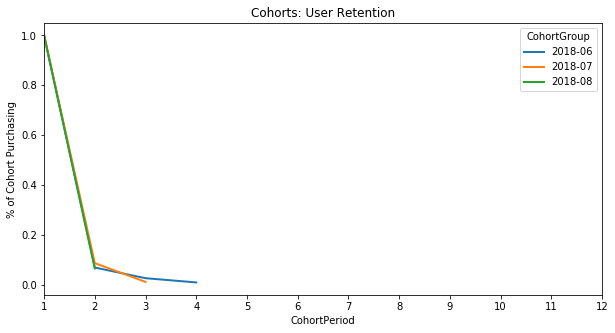

In [11]:
user_retention[['2018-06', '2018-07', '2018-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

세 집단모두 다음달의 이탈율이 높은 것으로 보입니다.

첫 월의 인원들이 가장 이탈율이 적어서 집중할 필요가 있습니다.

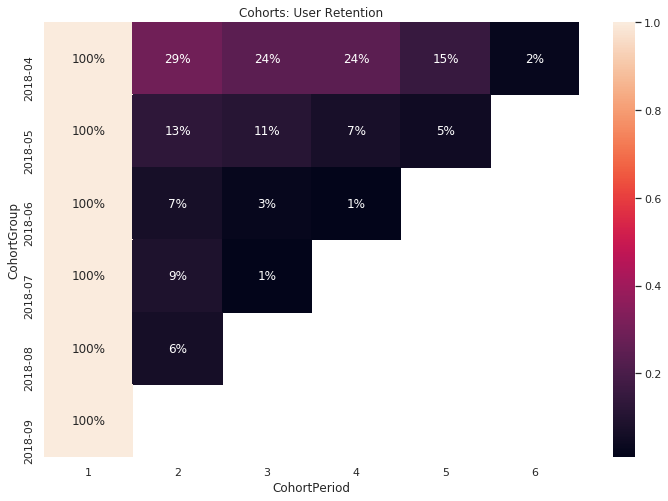

In [13]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');